In [25]:
# 清空内核状态
%reset -f

In [26]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(123456)

In [27]:
#要设置的参数
Ex=0#E也要放小e6倍，这里是0就不放了
Ey=0
Ez=0#托卡马克里面没电场
B0=5#磁轴中心的磁感应强度为5T
q=2.5#安全因子，注意，不是电荷
R0=6.2#托卡马克大半径6.2m
q_over_m = 4.822452834e1  # 电荷与质量之比

#单位问题：跑太大的数，程序吃不消，得归一化。几个大数，q_over_m = 4.8e7，vx0vy0 1e6 5e6，interval 4.1473e-9，要动
#程序中，要让轨迹相对形状不变，又因为B和位置有关，所以轨迹数值也不能变
#a=q/m（E+vB），x=vt+0.5at^2
#让位移x=vt+0.5at^2不变，让interval扩大e6倍，让v缩小e6倍(让v0和x0在同一量级，这样好训练)，让q_over_m缩小e6倍，E也要放小e6倍，这样a放小e12个
def Bx(x,y,z):
    return B0/q*(-q*R0*y+z*x)/(x**2+y**2)
def By(x,y,z):
    return B0/q*(q*R0*x+z*y)/(x**2+y**2)
def Bz(x,y,z):
    return B0/q*(-1+R0/(x**2+y**2)**0.5)
    

target_x0=torch.tensor([7.2])
target_y0=torch.tensor([0.0])
target_z0=torch.tensor([0.0])
target_vx0=torch.tensor([1.0])
target_vy0=torch.tensor([5.0])#这里是通行α粒子数据
target_vz0=torch.tensor([0.0])


interval=4.147267104135095e-4#根据学长给的数据取值,e-3是小圈的1/2π,e-4就是小圈的60分之一，更精确
#总运动时间是n*interval
learning_rate=8e-4

stop_condition = 5e-4#停止训练的loss值要求


#设置初始权重
lamda1=1#lpde权重
lamda2=1#lE权重
lamda3=1#l0权重




In [28]:
n=100#训练中的t共n个时间点,注意画三维图的点不建议超过200个，容易炸内核
n_all=500#总覆盖时间点数，绘图用
jump=0#单位是interval
n_epoch=100#每几次epoch就计数

n_test=50#在n_all范围内，等距取多少个test点
new_prefix = "8.2.duansui-weight"  # 新的文件名前缀

In [29]:
#Neural Network
#t作为输入，x,y,z作为输出，中间三个隐藏层
#MLP是最基础的全连接神经网络

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        self.a = nn.Parameter(torch.tensor(0.1))  # 将a设置为可学习的参数

    def forward(self, x):
        return torch.sin(self.a *10* x)

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1,128),#0层
            SinActivation(),#1层
            torch.nn.Linear(128,128),#2层
            SinActivation(),#3
            torch.nn.Linear(128,128),#4
            SinActivation(),#5
            torch.nn.Linear(128,128),#6
            SinActivation(),#7
            torch.nn.Linear(128,3),#8
        )
         # 对每个线性层进行Glorot初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    def forward(self,x):
        return self.net(x)
    
    
u = MLP()  # 网络名称



In [30]:
# import torch
# #from ceshi_Copy1 import MLP  # 导入你的模型类定义

# # 创建模型实例
# # u = MyModel()

# # 加载模型参数
# u.load_state_dict(torch.load('3.1.1保存.pth'))

# # 设置模型为评估模式（如果只是进行推理）
# # u.eval()

In [31]:


#下面是求导
def gradients(x,t,order=1):
    if order == 1:
        return torch.autograd.grad(x,t,grad_outputs=torch.ones_like(x),#用于计算某个标量相对于一组输入张量的梯度
                                  create_graph = True,
                                  only_inputs=True,)[0]#create_graph： 这是一个布尔值，如果设置为 True，则创建一个用于计算更高阶梯度的计算图。
                                                    #这对于执行高阶梯度的操作是有用的。在训练深度学习模型时，可能需要计算模型参数的二阶梯度。
    else:
        return gradients(gradients(x,t),t,order = order-1)#二阶及以上导

In [32]:


#损失函数
#LOSS
loss = torch.nn.MSELoss()
tensortarget = (target_vx0**2+target_vy0**2+target_vz0**2)**0.5
target_initial = tensortarget.repeat(n+1).view(-1, 1)#保能量项用的

def funcmiu(x,y,z,vx,vy,vz):
    miu=(vx**2+vy**2+vz**2)/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**0.5-(vx*Bx(x,y,z)+vy*By(x,y,z)+vz*Bz(x,y,z))**2/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**1.5
    return miu


def LOSS(u):
    
    samples = torch.arange(jump*interval, (n_all+1+jump)*interval, step=int(n_all/n)*interval)+torch.rand(n+1) * interval*int(n_all/n)*1   #random jitter to samples 10%#实际上n+1个点
    t = samples.view(-1, 1).requires_grad_(True)
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

    t0=torch.tensor([0.0]).requires_grad_(True)
    l00=(u(t0)[0] - target_x0)**2
    l01=(u(t0)[1] - target_y0)**2
    l02=(u(t0)[2] - target_z0)**2
    l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
    l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
    l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
    l0=l00+l01+l02+l03+l04+l05

    return lpde,lE,l0


In [33]:
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)
def funcweight(lpde):
    lpde.backward(retain_graph=True)#初态只对第0层的weight的梯度才全是0，其他情况都有梯度
    # 获取网络的参数列表
    gradientlw0 = u.net[0].weight.grad.clone()
    gradientlb0 = u.net[0].bias.grad.clone()
    gradientlw2 = u.net[2].weight.grad.clone()
    gradientlb2 = u.net[2].bias.grad.clone()
    gradientlw4 = u.net[4].weight.grad.clone()
    gradientlb4 = u.net[4].bias.grad.clone()
    gradientlw6 = u.net[6].weight.grad.clone()
    gradientlb6 = u.net[6].bias.grad.clone()
    gradientlw8 = u.net[8].weight.grad.clone()
    gradientlb8 = u.net[8].bias.grad.clone()
    opt.zero_grad()
    tensors_l = [gradientlw0,gradientlb0,gradientlw2,gradientlb2,gradientlw4,gradientlb4,gradientlw6,gradientlb6,
                gradientlw8,gradientlb8]
    squared_sums = [torch.sum(tensor ** 2) for tensor in tensors_l]
    # 将所有平方和相加
    total_squared_sum = sum(squared_sums)
    l2_norm_gradient_l=(total_squared_sum.item())**0.5
    return l2_norm_gradient_l

In [34]:
# 加载文本文件
xdata = np.loadtxt('通行x_real.txt')
# 从第四个数据开始，每隔10个数据读取一个，共读取50个数据
xselected_data = xdata[jump::int(n_all/n_test)][:(n_test+1)]
# 将所选数据转换为PyTorch张量
x_real = torch.tensor(xselected_data, dtype=torch.float32).view(-1,1)

ydata = np.loadtxt('通行y_real.txt')
yselected_data = ydata[jump::int(n_all/n_test)][:(n_test+1)]
y_real = torch.tensor(yselected_data, dtype=torch.float32).view(-1,1)

zdata = np.loadtxt('通行z_real.txt')
zselected_data = zdata[jump::int(n_all/n_test)][:(n_test+1)]
z_real = torch.tensor(zselected_data, dtype=torch.float32).view(-1,1)



#全500点，用于后续绘图
x_plt=xdata[jump:(n_all+1+jump):1]
y_plt=ydata[jump:(n_all+1+jump):1]
z_plt=zdata[jump:(n_all+1+jump):1]
x_real_plt=torch.tensor(x_plt, dtype=torch.float32).view(-1,1)#真实值的0~500点，
y_real_plt=torch.tensor(y_plt, dtype=torch.float32).view(-1,1)
z_real_plt=torch.tensor(z_plt, dtype=torch.float32).view(-1,1)
vxdata = (np.loadtxt('通行vx_real.txt'))*1e-6
vydata = (np.loadtxt('通行vy_real.txt'))*1e-6
vzdata = (np.loadtxt('通行vz_real.txt'))*1e-6
vx_real_plt=torch.tensor(vxdata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
vy_real_plt=torch.tensor(vydata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
vz_real_plt=torch.tensor(vzdata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
xdata=[]
ydata=[]
zdata=[]
vxdata=[]
vydata=[]
vzdata=[]#清空这二百四十万个数据

#x_real：用于训练过程神经网络输出值与真实值对比，3，13,23…493共50个时刻点，对应t_test
#x_real_plt：用于绘制真实图，0~500全点


In [35]:
#训练过程中记录的量
loss_list=[]#总损失，带权重
lpde_list=[]#方程项损失
l0_list=[]#初态损失
lE_list=[]#能量项损失loss，也是与真实能量做对比diff
lamda1_list=[]#方程项权重，把保能量保磁矩也放在这一项
lamda2_list=[]#能量项权重
lamda3_list=[]#初态权重
l_withoutweight_list=[]#总损失，不带权重
time_list=[]#训练时间记录
loss_test_list=[]#部分时刻点，输出位置与真实位置误差向量的模平方，即位置与真实值的误差
lossmean_test_list=[]#部分时刻点，输出位置与真实位置误差的算术平均值，(sigma（xn+yn+zn）-sigma(xc+yc+zc))/n ,证明轨迹可以视为导心
miu_train_list=[]

In [36]:
import time
start_time = time.time()#计时
epochs = 100000  #训练次数
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)

for i in range(epochs):
    opt.zero_grad()
    
    lpde=LOSS(u)[0]
    lE=LOSS(u)[1]
    l0=LOSS(u)[2]
  
#     if (i+1)%1000== 0:
#         gradient_lpde=funcweight(lpde)
#         gradient_lE=funcweight(lE)
#         gradient_l0=funcweight(l0) 

#     if (i+1)%1000== 0 and lpde>1e-5:
#         lamda1=0.2*lamda1+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lpde  )
#     if (i+1)%1000== 0 and l0>1e-5:
#         lamda3=0.2*lamda3+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_l0  )
#     if (i+1)%1000== 0 and lE>1e-5:
#         lamda2=0.2*lamda2+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lE  )
        
    l_total=lamda1*lpde+lamda3*l0+lamda2*lE
    l_withoutweight=lpde+l0+lE
    l_total.backward()
    opt.step()
    
    
    if (i+1)%1000 == 0:
        learnr = opt.param_groups[0]['lr']
        
        #更新学习率
        learning_rate *=0.952
        for param_group in opt.param_groups:
            param_group['lr'] = learning_rate
    
    
    

    if (i+1)%n_epoch == 0 or i==0:
        end_time = time.time()
        total_time = end_time - start_time
        learnr = opt.param_groups[0]['lr']
        time_test =torch.arange(interval*jump, interval*(n_all+1+jump), interval*int(n_all/n_test))
        t_test = time_test.view(-1, 1).requires_grad_(True)
        x_test = u(t_test)[:, 0].view(-1, 1)
        y_test = u(t_test)[:, 1].view(-1, 1)
        z_test = u(t_test)[:, 2].view(-1, 1)
        vx_test = gradients(x_test,t_test,1)
        vy_test = gradients(y_test,t_test,1)
        vz_test = gradients(z_test,t_test,1)
        loss_test = loss(x_test,x_real)+loss(y_test,y_real)+loss(z_test,z_real)
        miu_train=funcmiu(x_test,y_test,z_test,vx_test,vy_test,vz_test)
        #lcq=lE+lmiu_test#注意这里！！
        lossmean_test = torch.sum(x_test-x_real+y_test-y_real+z_test-z_real)/n
        print(f'Epoch [{i+1}/{epochs}], Loss: {l_total.item():.4g},   LOSS_function: {lpde.item():.4g},   LOSS_E:{lE.item():.4g},    LOSS_initial: {l0.item():.4g},')
        print(f'lamda1:{lamda1:.4g},    lamda2:{lamda2:.4g},    lamda3:{lamda3:.4g},      learn rate:{learnr:.4g},    time: {total_time}' )
        print(f'loss_compared with real:{loss_test:.5g},   miu_train:{miu_train.mean():.4g},    lossmean:{lossmean_test.item():.4g}') 
        loss_list.append(l_total.item())
        lpde_list.append(lpde.item())
        l0_list.append(l0.item())
        lE_list.append(lE.item())
        lamda1_list.append(lamda1)
        lamda2_list.append(lamda2)
        lamda3_list.append(lamda3)
        l_withoutweight_list.append(l_withoutweight.item())
        time_list.append(total_time)
        loss_test_list.append(loss_test.item())
        lossmean_test_list.append(lossmean_test.item())
        miu_train_list.append(miu_train.mean())
    
    if (i+1)%4000 == 0:
        for name, param in u.named_parameters():
            if 'a' in name:  # 筛选出包含'a'的参数
                print(name, param)
        
        
    if l_total <= stop_condition:#刚才写成loss_test了，感觉不妥，毕竟应该不知道真实数字是多少
        print(f'Training stopped at No.{i+1} time. Loss ({l_total}) is below the specified threshold ({stop_condition}).')
        break


Epoch [1/100000], Loss: 1.015e+05,   LOSS_function: 6.066e+04,   LOSS_E:24.65,    LOSS_initial: 68.01,
lamda1:1,    lamda3:600,      learn rate:0.0005,    time: 0.04451441764831543
loss_compared with real:32.248,   miu_train:1.297e-05,    lossmean:-15.81
Epoch [100/100000], Loss: 3722,   LOSS_function: 108.2,   LOSS_E:5.312,    LOSS_initial: 6.023,
lamda1:1,    lamda3:600,      learn rate:0.0005,    time: 3.4768829345703125
loss_compared with real:0.36871,   miu_train:0.000569,    lossmean:-1.388
Epoch [200/100000], Loss: 418.6,   LOSS_function: 17.32,   LOSS_E:0.008967,    LOSS_initial: 0.6688,
lamda1:1,    lamda3:600,      learn rate:0.0005,    time: 6.985980033874512
loss_compared with real:0.21729,   miu_train:0.0002199,    lossmean:-0.7704
Epoch [300/100000], Loss: 421.9,   LOSS_function: 10.7,   LOSS_E:0.006354,    LOSS_initial: 0.6852,
lamda1:1,    lamda3:600,      learn rate:0.0005,    time: 10.713253498077393
loss_compared with real:0.20782,   miu_train:0.0003432,    lossmean:

Epoch [3200/100000], Loss: 565.1,   LOSS_function: 16.51,   LOSS_E:0.005645,    LOSS_initial: 0.6498,
lamda1:1.002,    lamda3:844.1,      learn rate:0.0004287,    time: 121.11282587051392
loss_compared with real:0.20002,   miu_train:0.0005412,    lossmean:-0.6489
Epoch [3300/100000], Loss: 575.5,   LOSS_function: 22.93,   LOSS_E:0.01465,    LOSS_initial: 0.6545,
lamda1:1.002,    lamda3:844.1,      learn rate:0.0004287,    time: 124.85600876808167
loss_compared with real:0.19488,   miu_train:0.0006686,    lossmean:-0.6888
Epoch [3400/100000], Loss: 554.1,   LOSS_function: 24.58,   LOSS_E:0.02001,    LOSS_initial: 0.6272,
lamda1:1.002,    lamda3:844.1,      learn rate:0.0004287,    time: 128.61217880249023
loss_compared with real:0.19201,   miu_train:0.0004465,    lossmean:-0.6834
Epoch [3500/100000], Loss: 559.3,   LOSS_function: 43.09,   LOSS_E:0.02148,    LOSS_initial: 0.6114,
lamda1:1.002,    lamda3:844.1,      learn rate:0.0004287,    time: 132.30889081954956
loss_compared with real

Epoch [4200/100000], Loss: 635.4,   LOSS_function: 48.76,   LOSS_E:0.004878,    LOSS_initial: 0.5951,
lamda1:1.001,    lamda3:985.7,      learn rate:0.0004073,    time: 159.6639485359192
loss_compared with real:0.19248,   miu_train:0.0003666,    lossmean:-0.6923
Epoch [4300/100000], Loss: 627,   LOSS_function: 50.05,   LOSS_E:0.01103,    LOSS_initial: 0.5853,
lamda1:1.001,    lamda3:985.7,      learn rate:0.0004073,    time: 163.82027578353882
loss_compared with real:0.18291,   miu_train:0.000397,    lossmean:-0.6561
Epoch [4400/100000], Loss: 629.4,   LOSS_function: 66.05,   LOSS_E:0.01181,    LOSS_initial: 0.5714,
lamda1:1.001,    lamda3:985.7,      learn rate:0.0004073,    time: 168.00016808509827
loss_compared with real:0.17704,   miu_train:0.0004265,    lossmean:-0.6329
Epoch [4500/100000], Loss: 625.5,   LOSS_function: 67.75,   LOSS_E:0.008299,    LOSS_initial: 0.5657,
lamda1:1.001,    lamda3:985.7,      learn rate:0.0004073,    time: 171.94562458992004
loss_compared with real:0.

Epoch [7400/100000], Loss: 785.2,   LOSS_function: 114.9,   LOSS_E:0.01261,    LOSS_initial: 0.5153,
lamda1:1.001,    lamda3:1301,      learn rate:0.0003492,    time: 275.7565951347351
loss_compared with real:0.16277,   miu_train:0.0006271,    lossmean:-0.5901
Epoch [7500/100000], Loss: 801.1,   LOSS_function: 102.5,   LOSS_E:0.006434,    LOSS_initial: 0.5371,
lamda1:1.001,    lamda3:1301,      learn rate:0.0003492,    time: 279.23112511634827
loss_compared with real:0.18188,   miu_train:0.001568,    lossmean:-0.6286
Epoch [7600/100000], Loss: 788.5,   LOSS_function: 85.3,   LOSS_E:0.005909,    LOSS_initial: 0.5406,
lamda1:1.001,    lamda3:1301,      learn rate:0.0003492,    time: 282.8305311203003
loss_compared with real:0.15905,   miu_train:0.0009164,    lossmean:-0.5839
Epoch [7700/100000], Loss: 766.3,   LOSS_function: 119.9,   LOSS_E:0.002951,    LOSS_initial: 0.4969,
lamda1:1.001,    lamda3:1301,      learn rate:0.0003492,    time: 286.551474571228
loss_compared with real:0.16361

Epoch [8400/100000], Loss: 1102,   LOSS_function: 256.9,   LOSS_E:0.03007,    LOSS_initial: 0.403,
lamda1:1.001,    lamda3:2096,      learn rate:0.0003317,    time: 311.80768036842346
loss_compared with real:0.13426,   miu_train:0.001674,    lossmean:-0.5389
Epoch [8500/100000], Loss: 1110,   LOSS_function: 269.5,   LOSS_E:0.0468,    LOSS_initial: 0.4012,
lamda1:1.001,    lamda3:2096,      learn rate:0.0003317,    time: 315.9006733894348
loss_compared with real:0.14152,   miu_train:0.002326,    lossmean:-0.5902
Epoch [8600/100000], Loss: 1199,   LOSS_function: 490.5,   LOSS_E:0.04781,    LOSS_initial: 0.338,
lamda1:1.001,    lamda3:2096,      learn rate:0.0003317,    time: 319.9927122592926
loss_compared with real:0.11343,   miu_train:0.001315,    lossmean:-0.4275
Epoch [8700/100000], Loss: 1071,   LOSS_function: 203.6,   LOSS_E:0.04467,    LOSS_initial: 0.4137,
lamda1:1.001,    lamda3:2096,      learn rate:0.0003317,    time: 324.02320289611816
loss_compared with real:0.12209,   miu_t

Epoch [11600/100000], Loss: 651,   LOSS_function: 293.6,   LOSS_E:0.01732,    LOSS_initial: 0.1121,
lamda1:1,    lamda3:3188,      learn rate:0.0002844,    time: 437.3135631084442
loss_compared with real:0.046637,   miu_train:0.005839,    lossmean:-0.2946
Epoch [11700/100000], Loss: 854.1,   LOSS_function: 270.7,   LOSS_E:0.02472,    LOSS_initial: 0.183,
lamda1:1,    lamda3:3188,      learn rate:0.0002844,    time: 441.17132019996643
loss_compared with real:0.016944,   miu_train:0.006177,    lossmean:-0.06519
Epoch [11800/100000], Loss: 820.4,   LOSS_function: 458.8,   LOSS_E:0.04208,    LOSS_initial: 0.1134,
lamda1:1,    lamda3:3188,      learn rate:0.0002844,    time: 445.0301704406738
loss_compared with real:0.052118,   miu_train:0.005264,    lossmean:-0.2846
Epoch [11900/100000], Loss: 967.6,   LOSS_function: 683,   LOSS_E:0.01241,    LOSS_initial: 0.0892,
lamda1:1,    lamda3:3188,      learn rate:0.0002844,    time: 448.9765832424164
loss_compared with real:0.071179,   miu_train:0

Epoch [12600/100000], Loss: 1772,   LOSS_function: 1426,   LOSS_E:0.01601,    LOSS_initial: 0.01428,
lamda1:1,    lamda3:2.416e+04,      learn rate:0.0002702,    time: 475.73981761932373
loss_compared with real:0.0038094,   miu_train:0.01556,    lossmean:0.01967
Epoch [12700/100000], Loss: 3454,   LOSS_function: 1776,   LOSS_E:0.01694,    LOSS_initial: 0.06941,
lamda1:1,    lamda3:2.416e+04,      learn rate:0.0002702,    time: 479.58579301834106
loss_compared with real:0.0022899,   miu_train:0.01563,    lossmean:-0.01051
Epoch [12800/100000], Loss: 2782,   LOSS_function: 1622,   LOSS_E:0.01404,    LOSS_initial: 0.04801,
lamda1:1,    lamda3:2.416e+04,      learn rate:0.0002702,    time: 483.5784993171692
loss_compared with real:0.0040607,   miu_train:0.01509,    lossmean:0.0253
Epoch [12900/100000], Loss: 1712,   LOSS_function: 1595,   LOSS_E:0.01468,    LOSS_initial: 0.004864,
lamda1:1,    lamda3:2.416e+04,      learn rate:0.0002702,    time: 488.07353472709656
loss_compared with real:

Epoch [15800/100000], Loss: 1221,   LOSS_function: 1035,   LOSS_E:0.08366,    LOSS_initial: 0.005963,
lamda1:1,    lamda3:3.125e+04,      learn rate:0.0002316,    time: 610.1281499862671
loss_compared with real:0.004182,   miu_train:0.007824,    lossmean:-0.04773
Epoch [15900/100000], Loss: 1132,   LOSS_function: 962.1,   LOSS_E:0.01106,    LOSS_initial: 0.005422,
lamda1:1,    lamda3:3.125e+04,      learn rate:0.0002316,    time: 614.4773986339569
loss_compared with real:0.00037495,   miu_train:0.009521,    lossmean:0.02737
Epoch [16000/100000], Loss: 1652,   LOSS_function: 1264,   LOSS_E:0.01186,    LOSS_initial: 0.02981,
lamda1:1,    lamda3:1.302e+04,      learn rate:0.0002201,    time: 618.9704594612122
loss_compared with real:0.00068851,   miu_train:0.00729,    lossmean:0.02011
net.0.bias Parameter containing:
tensor([-0.5340, -0.5368, -0.3152, -0.9703, -0.0661, -0.3381,  0.4480, -0.8475,
         0.8903,  0.3259,  0.7841,  0.5445,  0.6489, -0.0365,  0.6927, -0.3409,
         0.868

Epoch [16800/100000], Loss: 494.9,   LOSS_function: 286.4,   LOSS_E:0.01645,    LOSS_initial: 0.01601,
lamda1:1,    lamda3:1.302e+04,      learn rate:0.0002201,    time: 655.1046919822693
loss_compared with real:0.0021924,   miu_train:0.01003,    lossmean:0.007008
Epoch [16900/100000], Loss: 740.7,   LOSS_function: 455.1,   LOSS_E:0.01286,    LOSS_initial: 0.02193,
lamda1:1,    lamda3:1.302e+04,      learn rate:0.0002201,    time: 659.6969857215881
loss_compared with real:0.0022753,   miu_train:0.008425,    lossmean:-0.06191
Epoch [17000/100000], Loss: 605.1,   LOSS_function: 367.1,   LOSS_E:0.01917,    LOSS_initial: 0.05399,
lamda1:1,    lamda3:4405,      learn rate:0.0002091,    time: 664.1822197437286
loss_compared with real:0.0047326,   miu_train:0.00562,    lossmean:-0.1015
Epoch [17100/100000], Loss: 509.1,   LOSS_function: 371.5,   LOSS_E:0.0142,    LOSS_initial: 0.03119,
lamda1:1,    lamda3:4405,      learn rate:0.0002091,    time: 668.961347579956
loss_compared with real:0.024

Epoch [20000/100000], Loss: 1444,   LOSS_function: 1169,   LOSS_E:0.0118,    LOSS_initial: 0.03939,
lamda1:1,    lamda3:6990,      learn rate:0.0001792,    time: 799.2198827266693
loss_compared with real:0.0011466,   miu_train:0.006984,    lossmean:-0.06471
net.0.bias Parameter containing:
tensor([-0.5330, -0.5339, -0.3143, -0.9695, -0.0657, -0.3373,  0.4467, -0.8419,
         0.8802,  0.3255,  0.7838,  0.5437,  0.6472, -0.0362,  0.6918, -0.3402,
         0.8627,  0.0301,  0.8047, -0.8372, -0.2802, -0.9661, -0.5070, -0.3442,
        -0.3284, -0.3883,  0.7342, -0.6552, -0.2595,  0.4393, -0.3366, -0.1998,
         0.1114,  0.6442, -0.7263, -0.8130, -0.7028, -0.5726, -0.2807, -0.0408,
        -0.8233, -0.9652, -0.0701,  0.8110, -0.6287,  0.8577, -0.6873,  0.9065,
         0.5996, -0.9510, -0.7628, -0.3579,  0.8561, -0.5832,  0.9135, -0.1265,
        -0.9060,  0.4238, -0.2759, -0.8673,  0.8213, -0.3161,  0.2741, -0.1162,
        -0.5540, -0.0842, -0.0299,  0.4217, -0.4126, -0.3659,  0.5867

Epoch [21000/100000], Loss: 1186,   LOSS_function: 950.8,   LOSS_E:0.01257,    LOSS_initial: 0.04175,
lamda1:1,    lamda3:5638,      learn rate:0.0001703,    time: 842.6507890224457
loss_compared with real:0.0047091,   miu_train:0.008485,    lossmean:-0.08706
Epoch [21100/100000], Loss: 405.9,   LOSS_function: 328.1,   LOSS_E:0.01488,    LOSS_initial: 0.01378,
lamda1:1,    lamda3:5638,      learn rate:0.0001703,    time: 846.8875033855438
loss_compared with real:0.0056771,   miu_train:0.008498,    lossmean:-0.08887
Epoch [21200/100000], Loss: 1301,   LOSS_function: 1179,   LOSS_E:0.01711,    LOSS_initial: 0.02169,
lamda1:1,    lamda3:5638,      learn rate:0.0001703,    time: 851.1037230491638
loss_compared with real:0.0090388,   miu_train:0.005721,    lossmean:-0.08535
Epoch [21300/100000], Loss: 662.3,   LOSS_function: 575.8,   LOSS_E:0.01853,    LOSS_initial: 0.01533,
lamda1:1,    lamda3:5638,      learn rate:0.0001703,    time: 855.2881820201874
loss_compared with real:0.0075413,   

Epoch [24100/100000], Loss: 470.4,   LOSS_function: 370.6,   LOSS_E:0.0168,    LOSS_initial: 0.03173,
lamda1:1,    lamda3:3142,      learn rate:0.000146,    time: 978.3040924072266
loss_compared with real:0.015688,   miu_train:0.007544,    lossmean:-0.1382
Epoch [24200/100000], Loss: 767.7,   LOSS_function: 687,   LOSS_E:0.007426,    LOSS_initial: 0.02563,
lamda1:1,    lamda3:3142,      learn rate:0.000146,    time: 982.7860598564148
loss_compared with real:0.0043381,   miu_train:0.005894,    lossmean:-0.09038
Epoch [24300/100000], Loss: 476.6,   LOSS_function: 387.3,   LOSS_E:0.01577,    LOSS_initial: 0.02838,
lamda1:1,    lamda3:3142,      learn rate:0.000146,    time: 987.2972042560577
loss_compared with real:0.01502,   miu_train:0.006209,    lossmean:-0.1497
Epoch [24400/100000], Loss: 760.9,   LOSS_function: 157.3,   LOSS_E:0.008012,    LOSS_initial: 0.1921,
lamda1:1,    lamda3:3142,      learn rate:0.000146,    time: 991.8215565681458
loss_compared with real:0.0084038,   miu_trai

Epoch [27300/100000], Loss: 810.1,   LOSS_function: 706.9,   LOSS_E:0.007345,    LOSS_initial: 0.04917,
lamda1:1.001,    lamda3:2093,      learn rate:0.0001252,    time: 1122.883641242981
loss_compared with real:0.020835,   miu_train:0.005178,    lossmean:-0.1277
Epoch [27400/100000], Loss: 683.5,   LOSS_function: 148.9,   LOSS_E:0.003732,    LOSS_initial: 0.2554,
lamda1:1.001,    lamda3:2093,      learn rate:0.0001252,    time: 1127.1040570735931
loss_compared with real:0.021095,   miu_train:0.003223,    lossmean:-0.1258
Epoch [27500/100000], Loss: 537,   LOSS_function: 140,   LOSS_E:0.01929,    LOSS_initial: 0.1897,
lamda1:1.001,    lamda3:2093,      learn rate:0.0001252,    time: 1131.5507135391235
loss_compared with real:0.017532,   miu_train:0.003817,    lossmean:-0.1562
Epoch [27600/100000], Loss: 420,   LOSS_function: 212.4,   LOSS_E:0.005008,    LOSS_initial: 0.09915,
lamda1:1.001,    lamda3:2093,      learn rate:0.0001252,    time: 1135.851683139801
loss_compared with real:0.0

Epoch [28100/100000], Loss: 267.5,   LOSS_function: 120.8,   LOSS_E:0.006685,    LOSS_initial: 0.05978,
lamda1:1,    lamda3:2454,      learn rate:0.0001189,    time: 1157.248955488205
loss_compared with real:0.010163,   miu_train:0.006325,    lossmean:-0.1197
Epoch [28200/100000], Loss: 674.2,   LOSS_function: 482,   LOSS_E:0.01158,    LOSS_initial: 0.07827,
lamda1:1,    lamda3:2454,      learn rate:0.0001189,    time: 1161.5154738426208
loss_compared with real:0.029362,   miu_train:0.00622,    lossmean:-0.1135
Epoch [28300/100000], Loss: 276.9,   LOSS_function: 121.5,   LOSS_E:0.009385,    LOSS_initial: 0.06329,
lamda1:1,    lamda3:2454,      learn rate:0.0001189,    time: 1165.727665424347
loss_compared with real:0.017463,   miu_train:0.005642,    lossmean:-0.1538
Epoch [28400/100000], Loss: 701.3,   LOSS_function: 610.2,   LOSS_E:0.01228,    LOSS_initial: 0.03701,
lamda1:1,    lamda3:2454,      learn rate:0.0001189,    time: 1169.9362080097198
loss_compared with real:0.022968,   miu

Epoch [31300/100000], Loss: 228.8,   LOSS_function: 144.2,   LOSS_E:0.01559,    LOSS_initial: 0.03936,
lamda1:1.001,    lamda3:2147,      learn rate:0.000102,    time: 1299.0735635757446
loss_compared with real:0.017783,   miu_train:0.007036,    lossmean:-0.1564
Epoch [31400/100000], Loss: 714.9,   LOSS_function: 616.5,   LOSS_E:0.01156,    LOSS_initial: 0.04568,
lamda1:1.001,    lamda3:2147,      learn rate:0.000102,    time: 1303.6094439029694
loss_compared with real:0.023788,   miu_train:0.006043,    lossmean:-0.161
Epoch [31500/100000], Loss: 803.8,   LOSS_function: 705.6,   LOSS_E:0.005692,    LOSS_initial: 0.04556,
lamda1:1.001,    lamda3:2147,      learn rate:0.000102,    time: 1308.1020188331604
loss_compared with real:0.0092875,   miu_train:0.005505,    lossmean:-0.07778
Epoch [31600/100000], Loss: 298.6,   LOSS_function: 136.1,   LOSS_E:0.01219,    LOSS_initial: 0.07567,
lamda1:1.001,    lamda3:2147,      learn rate:0.000102,    time: 1312.9257900714874
loss_compared with rea

Epoch [32300/100000], Loss: 725.2,   LOSS_function: 612.7,   LOSS_E:0.01454,    LOSS_initial: 0.006139,
lamda1:1,    lamda3:1.831e+04,      learn rate:9.686e-05,    time: 1344.9248685836792
loss_compared with real:0.00035157,   miu_train:0.01013,    lossmean:-0.02167
Epoch [32400/100000], Loss: 1252,   LOSS_function: 1189,   LOSS_E:0.008665,    LOSS_initial: 0.003424,
lamda1:1,    lamda3:1.831e+04,      learn rate:9.686e-05,    time: 1349.4673385620117
loss_compared with real:0.00015143,   miu_train:0.008789,    lossmean:-0.02129
Epoch [32500/100000], Loss: 1657,   LOSS_function: 1466,   LOSS_E:0.009236,    LOSS_initial: 0.01044,
lamda1:1,    lamda3:1.831e+04,      learn rate:9.686e-05,    time: 1353.9834339618683
loss_compared with real:0.0009798,   miu_train:0.007876,    lossmean:0.001163
Epoch [32600/100000], Loss: 266.1,   LOSS_function: 233,   LOSS_E:0.01286,    LOSS_initial: 0.001805,
lamda1:1,    lamda3:1.831e+04,      learn rate:9.686e-05,    time: 1358.5005991458893
loss_compa

Epoch [35400/100000], Loss: 372.8,   LOSS_function: 225.5,   LOSS_E:0.009638,    LOSS_initial: 0.01207,
lamda1:1,    lamda3:1.221e+04,      learn rate:8.304e-05,    time: 1482.7644155025482
loss_compared with real:0.00059188,   miu_train:0.01082,    lossmean:-0.003115
Epoch [35500/100000], Loss: 1134,   LOSS_function: 1098,   LOSS_E:0.009023,    LOSS_initial: 0.002933,
lamda1:1,    lamda3:1.221e+04,      learn rate:8.304e-05,    time: 1487.0416600704193
loss_compared with real:0.0014829,   miu_train:0.007896,    lossmean:-0.03008
Epoch [35600/100000], Loss: 354.7,   LOSS_function: 183.1,   LOSS_E:0.01113,    LOSS_initial: 0.01405,
lamda1:1,    lamda3:1.221e+04,      learn rate:8.304e-05,    time: 1491.339938879013
loss_compared with real:0.0014239,   miu_train:0.008684,    lossmean:-0.01216
Epoch [35700/100000], Loss: 234.3,   LOSS_function: 218.7,   LOSS_E:0.01515,    LOSS_initial: 0.001279,
lamda1:1,    lamda3:1.221e+04,      learn rate:8.304e-05,    time: 1495.8384699821472
loss_com

Epoch [36400/100000], Loss: 185.2,   LOSS_function: 164.9,   LOSS_E:0.01609,    LOSS_initial: 0.003541,
lamda1:1,    lamda3:5724,      learn rate:7.889e-05,    time: 1526.3744637966156
loss_compared with real:0.00055832,   miu_train:0.009412,    lossmean:-0.04712
Epoch [36500/100000], Loss: 208.4,   LOSS_function: 178.8,   LOSS_E:0.0111,    LOSS_initial: 0.005173,
lamda1:1,    lamda3:5724,      learn rate:7.889e-05,    time: 1530.9080259799957
loss_compared with real:0.0010395,   miu_train:0.009198,    lossmean:-0.07426
Epoch [36600/100000], Loss: 237.8,   LOSS_function: 173.8,   LOSS_E:0.01642,    LOSS_initial: 0.01118,
lamda1:1,    lamda3:5724,      learn rate:7.889e-05,    time: 1535.4280574321747
loss_compared with real:0.0039375,   miu_train:0.008929,    lossmean:-0.02648
Epoch [36700/100000], Loss: 266.9,   LOSS_function: 147.5,   LOSS_E:0.01316,    LOSS_initial: 0.02085,
lamda1:1,    lamda3:5724,      learn rate:7.889e-05,    time: 1540.0237176418304
loss_compared with real:0.00

Epoch [39600/100000], Loss: 210.5,   LOSS_function: 154.1,   LOSS_E:0.006625,    LOSS_initial: 0.03866,
lamda1:1.001,    lamda3:1455,      learn rate:6.764e-05,    time: 1674.6851437091827
loss_compared with real:0.017402,   miu_train:0.006555,    lossmean:-0.1202
Epoch [39700/100000], Loss: 222.2,   LOSS_function: 122.5,   LOSS_E:0.01522,    LOSS_initial: 0.06842,
lamda1:1.001,    lamda3:1455,      learn rate:6.764e-05,    time: 1679.34441781044
loss_compared with real:0.015747,   miu_train:0.005868,    lossmean:-0.1372
Epoch [39800/100000], Loss: 277.4,   LOSS_function: 134.5,   LOSS_E:0.01631,    LOSS_initial: 0.09809,
lamda1:1.001,    lamda3:1455,      learn rate:6.764e-05,    time: 1683.9610924720764
loss_compared with real:0.026472,   miu_train:0.005863,    lossmean:-0.1185
Epoch [39900/100000], Loss: 242.6,   LOSS_function: 130.8,   LOSS_E:0.008591,    LOSS_initial: 0.07675,
lamda1:1.001,    lamda3:1455,      learn rate:6.764e-05,    time: 1688.5471415519714
loss_compared with r

Epoch [40400/100000], Loss: 242.4,   LOSS_function: 92.77,   LOSS_E:0.008948,    LOSS_initial: 0.1777,
lamda1:1.001,    lamda3:841.2,      learn rate:6.426e-05,    time: 1711.5985009670258
loss_compared with real:0.037092,   miu_train:0.004659,    lossmean:-0.182
Epoch [40500/100000], Loss: 215.7,   LOSS_function: 130,   LOSS_E:0.007391,    LOSS_initial: 0.1017,
lamda1:1.001,    lamda3:841.2,      learn rate:6.426e-05,    time: 1716.2058839797974
loss_compared with real:0.050399,   miu_train:0.004656,    lossmean:-0.2148
Epoch [40600/100000], Loss: 188.2,   LOSS_function: 72.88,   LOSS_E:0.008452,    LOSS_initial: 0.137,
lamda1:1.001,    lamda3:841.2,      learn rate:6.426e-05,    time: 1720.5405645370483
loss_compared with real:0.038135,   miu_train:0.004189,    lossmean:-0.214
Epoch [40700/100000], Loss: 381.6,   LOSS_function: 226.5,   LOSS_E:0.007192,    LOSS_initial: 0.184,
lamda1:1.001,    lamda3:841.2,      learn rate:6.426e-05,    time: 1724.8537142276764
loss_compared with rea

Epoch [43600/100000], Loss: 237.8,   LOSS_function: 192.9,   LOSS_E:0.01392,    LOSS_initial: 0.01713,
lamda1:1,    lamda3:2617,      learn rate:5.509e-05,    time: 1853.4662170410156
loss_compared with real:0.0076255,   miu_train:0.008372,    lossmean:-0.1041
Epoch [43700/100000], Loss: 227.7,   LOSS_function: 157,   LOSS_E:0.008325,    LOSS_initial: 0.02699,
lamda1:1,    lamda3:2617,      learn rate:5.509e-05,    time: 1858.1923174858093
loss_compared with real:0.0063824,   miu_train:0.008077,    lossmean:-0.07612
Epoch [43800/100000], Loss: 230.7,   LOSS_function: 172.4,   LOSS_E:0.01583,    LOSS_initial: 0.02223,
lamda1:1,    lamda3:2617,      learn rate:5.509e-05,    time: 1862.9169962406158
loss_compared with real:0.0063344,   miu_train:0.008394,    lossmean:-0.07759
Epoch [43900/100000], Loss: 213.6,   LOSS_function: 109.2,   LOSS_E:0.01134,    LOSS_initial: 0.03986,
lamda1:1,    lamda3:2617,      learn rate:5.509e-05,    time: 1867.5745899677277
loss_compared with real:0.007415

Epoch [44600/100000], Loss: 512,   LOSS_function: 304.2,   LOSS_E:0.01196,    LOSS_initial: 0.06855,
lamda1:1,    lamda3:3030,      learn rate:5.234e-05,    time: 1900.3055584430695
loss_compared with real:0.0046527,   miu_train:0.008162,    lossmean:-0.04658
Epoch [44700/100000], Loss: 365.4,   LOSS_function: 184.2,   LOSS_E:0.01386,    LOSS_initial: 0.05978,
lamda1:1,    lamda3:3030,      learn rate:5.234e-05,    time: 1904.9383943080902
loss_compared with real:0.007513,   miu_train:0.007888,    lossmean:-0.06502
Epoch [44800/100000], Loss: 625.8,   LOSS_function: 573.6,   LOSS_E:0.00971,    LOSS_initial: 0.01715,
lamda1:1,    lamda3:3030,      learn rate:5.234e-05,    time: 1909.5491743087769
loss_compared with real:0.0040261,   miu_train:0.009185,    lossmean:-0.06282
Epoch [44900/100000], Loss: 222.3,   LOSS_function: 174.3,   LOSS_E:0.0189,    LOSS_initial: 0.01583,
lamda1:1,    lamda3:3030,      learn rate:5.234e-05,    time: 1914.1938321590424
loss_compared with real:0.0076411,

Epoch [47800/100000], Loss: 236.1,   LOSS_function: 188.8,   LOSS_E:0.01127,    LOSS_initial: 0.02724,
lamda1:1.001,    lamda3:1732,      learn rate:4.487e-05,    time: 2047.2454447746277
loss_compared with real:0.0097555,   miu_train:0.007816,    lossmean:-0.09282
Epoch [47900/100000], Loss: 180.5,   LOSS_function: 113.6,   LOSS_E:0.01002,    LOSS_initial: 0.0386,
lamda1:1.001,    lamda3:1732,      learn rate:4.487e-05,    time: 2051.538078546524
loss_compared with real:0.0076853,   miu_train:0.007426,    lossmean:-0.06786
Epoch [48000/100000], Loss: 365.1,   LOSS_function: 233.1,   LOSS_E:0.009613,    LOSS_initial: 0.0292,
lamda1:1,    lamda3:4516,      learn rate:4.263e-05,    time: 2055.8523938655853
loss_compared with real:0.0090479,   miu_train:0.007557,    lossmean:-0.08052
net.0.bias Parameter containing:
tensor([-0.5308, -0.5300, -0.3131, -0.9704, -0.0655, -0.3348,  0.4445, -0.8275,
         0.8678,  0.3231,  0.7656,  0.5196,  0.6415, -0.0360,  0.6861, -0.3367,
         0.8565

Epoch [48800/100000], Loss: 187.1,   LOSS_function: 163.2,   LOSS_E:0.01037,    LOSS_initial: 0.005275,
lamda1:1,    lamda3:4516,      learn rate:4.263e-05,    time: 2091.149892807007
loss_compared with real:0.0018076,   miu_train:0.01048,    lossmean:-0.03419
Epoch [48900/100000], Loss: 262.2,   LOSS_function: 244.2,   LOSS_E:0.01243,    LOSS_initial: 0.003973,
lamda1:1,    lamda3:4516,      learn rate:4.263e-05,    time: 2095.645071744919
loss_compared with real:0.0034872,   miu_train:0.0109,    lossmean:-0.04069
Epoch [49000/100000], Loss: 184.4,   LOSS_function: 163.8,   LOSS_E:0.01004,    LOSS_initial: 0.004489,
lamda1:1,    lamda3:4594,      learn rate:4.05e-05,    time: 2100.03724861145
loss_compared with real:0.0018931,   miu_train:0.01063,    lossmean:-0.04647
Epoch [49100/100000], Loss: 969.6,   LOSS_function: 955.5,   LOSS_E:0.01134,    LOSS_initial: 0.003034,
lamda1:1,    lamda3:4594,      learn rate:4.05e-05,    time: 2104.391075849533
loss_compared with real:0.0020551,   

Epoch [52000/100000], Loss: 841.3,   LOSS_function: 744.7,   LOSS_E:0.00933,    LOSS_initial: 0.0037,
lamda1:1,    lamda3:2.609e+04,      learn rate:3.472e-05,    time: 2239.4027860164642
loss_compared with real:0.0014825,   miu_train:0.01087,    lossmean:-0.04302
net.0.bias Parameter containing:
tensor([-0.5308, -0.5299, -0.3130, -0.9703, -0.0655, -0.3349,  0.4444, -0.8274,
         0.8677,  0.3230,  0.7661,  0.5181,  0.6411, -0.0360,  0.6861, -0.3365,
         0.8563,  0.0303,  0.7949, -0.8443, -0.2787, -0.9690, -0.5014, -0.3423,
        -0.3266, -0.3854,  0.7216, -0.6413, -0.2548,  0.4331, -0.3341, -0.1942,
         0.1097,  0.6404, -0.7152, -0.7881, -0.6956, -0.5696, -0.2723, -0.0392,
        -0.8239, -0.9701, -0.0694,  0.8151, -0.6260,  0.8566, -0.6784,  0.9100,
         0.5958, -0.9524, -0.7576, -0.3562,  0.8563, -0.5510,  0.9351, -0.1267,
        -0.9125,  0.4203, -0.2728, -0.8650,  0.8220, -0.3140,  0.2725, -0.1146,
        -0.5477, -0.0830, -0.0299,  0.4181, -0.4096, -0.3634, 

Epoch [53000/100000], Loss: 195.1,   LOSS_function: 185.6,   LOSS_E:0.01179,    LOSS_initial: 0.0007917,
lamda1:1,    lamda3:1.193e+04,      learn rate:3.299e-05,    time: 2286.4223906993866
loss_compared with real:0.00010789,   miu_train:0.01191,    lossmean:0.007194
Epoch [53100/100000], Loss: 179.4,   LOSS_function: 168.3,   LOSS_E:0.01152,    LOSS_initial: 0.0009249,
lamda1:1,    lamda3:1.193e+04,      learn rate:3.299e-05,    time: 2291.0748443603516
loss_compared with real:0.00027909,   miu_train:0.01135,    lossmean:-0.01647
Epoch [53200/100000], Loss: 203.9,   LOSS_function: 194,   LOSS_E:0.009862,    LOSS_initial: 0.0008285,
lamda1:1,    lamda3:1.193e+04,      learn rate:3.299e-05,    time: 2295.8174500465393
loss_compared with real:8.1276e-05,   miu_train:0.01114,    lossmean:-0.00435
Epoch [53300/100000], Loss: 320,   LOSS_function: 206.5,   LOSS_E:0.01641,    LOSS_initial: 0.009513,
lamda1:1,    lamda3:1.193e+04,      learn rate:3.299e-05,    time: 2300.4290449619293
loss_c

Epoch [56100/100000], Loss: 845.4,   LOSS_function: 839.4,   LOSS_E:0.009579,    LOSS_initial: 0.0001245,
lamda1:1,    lamda3:4.794e+04,      learn rate:2.828e-05,    time: 2427.5903248786926
loss_compared with real:3.5969e-05,   miu_train:0.01193,    lossmean:0.00308
Epoch [56200/100000], Loss: 207.7,   LOSS_function: 203.8,   LOSS_E:0.009328,    LOSS_initial: 8.147e-05,
lamda1:1,    lamda3:4.794e+04,      learn rate:2.828e-05,    time: 2432.487504005432
loss_compared with real:2.4682e-05,   miu_train:0.01231,    lossmean:0.0001258
Epoch [56300/100000], Loss: 246.1,   LOSS_function: 176.7,   LOSS_E:0.01012,    LOSS_initial: 0.001448,
lamda1:1,    lamda3:4.794e+04,      learn rate:2.828e-05,    time: 2437.2231662273407
loss_compared with real:6.9494e-05,   miu_train:0.01249,    lossmean:-0.002273
Epoch [56400/100000], Loss: 620,   LOSS_function: 538.6,   LOSS_E:0.01177,    LOSS_initial: 0.001699,
lamda1:1,    lamda3:4.794e+04,      learn rate:2.828e-05,    time: 2441.929179906845
loss_

Epoch [59200/100000], Loss: 230.6,   LOSS_function: 208.6,   LOSS_E:0.009861,    LOSS_initial: 0.001889,
lamda1:1,    lamda3:1.166e+04,      learn rate:2.425e-05,    time: 2574.942732810974
loss_compared with real:0.0001186,   miu_train:0.01161,    lossmean:-0.007659
Epoch [59300/100000], Loss: 139.2,   LOSS_function: 132.3,   LOSS_E:0.009901,    LOSS_initial: 0.0005893,
lamda1:1,    lamda3:1.166e+04,      learn rate:2.425e-05,    time: 2579.6958656311035
loss_compared with real:0.00026577,   miu_train:0.01244,    lossmean:-0.0009923
Epoch [59400/100000], Loss: 187.1,   LOSS_function: 175,   LOSS_E:0.01019,    LOSS_initial: 0.001042,
lamda1:1,    lamda3:1.166e+04,      learn rate:2.425e-05,    time: 2584.437907934189
loss_compared with real:0.00011733,   miu_train:0.01169,    lossmean:-0.01647
Epoch [59500/100000], Loss: 171.8,   LOSS_function: 152.1,   LOSS_E:0.01225,    LOSS_initial: 0.001684,
lamda1:1,    lamda3:1.166e+04,      learn rate:2.425e-05,    time: 2589.076587677002
loss_c

Epoch [60200/100000], Loss: 388.3,   LOSS_function: 362.3,   LOSS_E:0.01279,    LOSS_initial: 0.004134,
lamda1:1,    lamda3:6284,      learn rate:2.303e-05,    time: 2622.1773619651794
loss_compared with real:0.0013142,   miu_train:0.01157,    lossmean:-0.01664
Epoch [60300/100000], Loss: 204.5,   LOSS_function: 185.8,   LOSS_E:0.01135,    LOSS_initial: 0.002974,
lamda1:1,    lamda3:6284,      learn rate:2.303e-05,    time: 2626.5826618671417
loss_compared with real:0.00098968,   miu_train:0.01205,    lossmean:-0.01968
Epoch [60400/100000], Loss: 221.9,   LOSS_function: 200.6,   LOSS_E:0.01352,    LOSS_initial: 0.003378,
lamda1:1,    lamda3:6284,      learn rate:2.303e-05,    time: 2630.980045080185
loss_compared with real:0.00078327,   miu_train:0.01133,    lossmean:-0.01535
Epoch [60500/100000], Loss: 168.2,   LOSS_function: 154.3,   LOSS_E:0.01028,    LOSS_initial: 0.002209,
lamda1:1,    lamda3:6284,      learn rate:2.303e-05,    time: 2635.3647150993347
loss_compared with real:0.00

Epoch [63400/100000], Loss: 189.4,   LOSS_function: 156.6,   LOSS_E:0.01199,    LOSS_initial: 0.0005702,
lamda1:1,    lamda3:5.755e+04,      learn rate:1.975e-05,    time: 2765.893094062805
loss_compared with real:2.5598e-05,   miu_train:0.01361,    lossmean:0.003165
Epoch [63500/100000], Loss: 449.3,   LOSS_function: 441.6,   LOSS_E:0.009469,    LOSS_initial: 0.0001342,
lamda1:1,    lamda3:5.755e+04,      learn rate:1.975e-05,    time: 2770.5094134807587
loss_compared with real:5.7603e-05,   miu_train:0.01282,    lossmean:0.0008185
Epoch [63600/100000], Loss: 203.8,   LOSS_function: 178.8,   LOSS_E:0.01039,    LOSS_initial: 0.0004346,
lamda1:1,    lamda3:5.755e+04,      learn rate:1.975e-05,    time: 2775.145519256592
loss_compared with real:5.1614e-05,   miu_train:0.01264,    lossmean:0.00183
Epoch [63700/100000], Loss: 196.9,   LOSS_function: 184.3,   LOSS_E:0.01114,    LOSS_initial: 0.0002192,
lamda1:1,    lamda3:5.755e+04,      learn rate:1.975e-05,    time: 2779.848948955536
loss

Epoch [64200/100000], Loss: 177,   LOSS_function: 171.1,   LOSS_E:0.0106,    LOSS_initial: 0.0003234,
lamda1:1,    lamda3:1.8e+04,      learn rate:1.876e-05,    time: 2803.4230518341064
loss_compared with real:0.00012451,   miu_train:0.01257,    lossmean:0.004785
Epoch [64300/100000], Loss: 173.8,   LOSS_function: 167.6,   LOSS_E:0.01108,    LOSS_initial: 0.0003387,
lamda1:1,    lamda3:1.8e+04,      learn rate:1.876e-05,    time: 2808.0800268650055
loss_compared with real:0.00018114,   miu_train:0.01305,    lossmean:0.00441
Epoch [64400/100000], Loss: 284.6,   LOSS_function: 249.8,   LOSS_E:0.01302,    LOSS_initial: 0.001933,
lamda1:1,    lamda3:1.8e+04,      learn rate:1.876e-05,    time: 2812.78515291214
loss_compared with real:0.0002049,   miu_train:0.01278,    lossmean:-0.005275
Epoch [64500/100000], Loss: 179.6,   LOSS_function: 143.1,   LOSS_E:0.0118,    LOSS_initial: 0.002026,
lamda1:1,    lamda3:1.8e+04,      learn rate:1.876e-05,    time: 2817.5121808052063
loss_compared with 

Epoch [67300/100000], Loss: 355.7,   LOSS_function: 340.2,   LOSS_E:0.01083,    LOSS_initial: 0.0002768,
lamda1:1,    lamda3:5.595e+04,      learn rate:1.609e-05,    time: 2954.139264345169
loss_compared with real:5.8844e-05,   miu_train:0.01362,    lossmean:-0.001821
Epoch [67400/100000], Loss: 164.9,   LOSS_function: 164,   LOSS_E:0.01259,    LOSS_initial: 1.514e-05,
lamda1:1,    lamda3:5.595e+04,      learn rate:1.609e-05,    time: 2958.7034480571747
loss_compared with real:2.8781e-05,   miu_train:0.01286,    lossmean:-0.00195
Epoch [67500/100000], Loss: 223.3,   LOSS_function: 197.5,   LOSS_E:0.0123,    LOSS_initial: 0.0004601,
lamda1:1,    lamda3:5.595e+04,      learn rate:1.609e-05,    time: 2963.2446298599243
loss_compared with real:4.2005e-05,   miu_train:0.01285,    lossmean:0.005627
Epoch [67600/100000], Loss: 177.7,   LOSS_function: 164.5,   LOSS_E:0.01251,    LOSS_initial: 0.000236,
lamda1:1,    lamda3:5.595e+04,      learn rate:1.609e-05,    time: 2967.82599067688
loss_com

Epoch [68300/100000], Loss: 219.7,   LOSS_function: 218,   LOSS_E:0.01171,    LOSS_initial: 3.217e-05,
lamda1:1,    lamda3:5.424e+04,      learn rate:1.528e-05,    time: 2999.0995543003082
loss_compared with real:3.6468e-05,   miu_train:0.01291,    lossmean:-0.002053
Epoch [68400/100000], Loss: 234.6,   LOSS_function: 232.6,   LOSS_E:0.01115,    LOSS_initial: 3.679e-05,
lamda1:1,    lamda3:5.424e+04,      learn rate:1.528e-05,    time: 3003.5204877853394
loss_compared with real:3.0928e-05,   miu_train:0.01311,    lossmean:0.005249
Epoch [68500/100000], Loss: 223.5,   LOSS_function: 212.5,   LOSS_E:0.01159,    LOSS_initial: 0.0002022,
lamda1:1,    lamda3:5.424e+04,      learn rate:1.528e-05,    time: 3007.976260662079
loss_compared with real:7.0853e-05,   miu_train:0.01333,    lossmean:-0.002743
Epoch [68600/100000], Loss: 166.4,   LOSS_function: 160.6,   LOSS_E:0.01034,    LOSS_initial: 0.0001068,
lamda1:1,    lamda3:5.424e+04,      learn rate:1.528e-05,    time: 3012.4022002220154
los

Epoch [71400/100000], Loss: 186.5,   LOSS_function: 169,   LOSS_E:0.011,    LOSS_initial: 0.0003545,
lamda1:1,    lamda3:4.949e+04,      learn rate:1.31e-05,    time: 3144.802004814148
loss_compared with real:2.6173e-05,   miu_train:0.01302,    lossmean:0.001175
Epoch [71500/100000], Loss: 251.9,   LOSS_function: 245.8,   LOSS_E:0.01175,    LOSS_initial: 0.0001243,
lamda1:1,    lamda3:4.949e+04,      learn rate:1.31e-05,    time: 3149.647750854492
loss_compared with real:3.7657e-05,   miu_train:0.01284,    lossmean:0.004452
Epoch [71600/100000], Loss: 164.6,   LOSS_function: 157.4,   LOSS_E:0.01168,    LOSS_initial: 0.0001451,
lamda1:1,    lamda3:4.949e+04,      learn rate:1.31e-05,    time: 3154.4048449993134
loss_compared with real:5.6322e-05,   miu_train:0.01359,    lossmean:0.0003449
Epoch [71700/100000], Loss: 466,   LOSS_function: 456.2,   LOSS_E:0.01082,    LOSS_initial: 0.0001978,
lamda1:1,    lamda3:4.949e+04,      learn rate:1.31e-05,    time: 3159.1918845176697
loss_compared

Epoch [72400/100000], Loss: 197.5,   LOSS_function: 182.4,   LOSS_E:0.01335,    LOSS_initial: 0.0003348,
lamda1:1,    lamda3:4.495e+04,      learn rate:1.245e-05,    time: 3192.7433240413666
loss_compared with real:6.5508e-05,   miu_train:0.01287,    lossmean:-0.00818
Epoch [72500/100000], Loss: 192.9,   LOSS_function: 180.4,   LOSS_E:0.01251,    LOSS_initial: 0.0002784,
lamda1:1,    lamda3:4.495e+04,      learn rate:1.245e-05,    time: 3197.5602555274963
loss_compared with real:5.9501e-05,   miu_train:0.01318,    lossmean:-0.004117
Epoch [72600/100000], Loss: 502.2,   LOSS_function: 495.7,   LOSS_E:0.01077,    LOSS_initial: 0.0001434,
lamda1:1,    lamda3:4.495e+04,      learn rate:1.245e-05,    time: 3202.361205101013
loss_compared with real:2.7277e-05,   miu_train:0.01312,    lossmean:0.004835
Epoch [72700/100000], Loss: 230.3,   LOSS_function: 225.5,   LOSS_E:0.01073,    LOSS_initial: 0.0001083,
lamda1:1,    lamda3:4.495e+04,      learn rate:1.245e-05,    time: 3207.145928621292
los

KeyboardInterrupt: 

In [48]:
old_uname='hh.pth'
#保存神经网络
torch.save(u.state_dict(), new_prefix + old_uname[2:])

In [49]:
file_lists = [loss_list, lpde_list, l0_list, lE_list, lamda1_list,lamda2_list, lamda3_list,l_withoutweight_list, time_list, loss_test_list, lossmean_test_list,miu_train_list]
file_names = ['hh_loss.txt', 'hh_lpde.txt', 'hh_l0.txt', 'hh_lE.txt', 'hh_lamda1.txt','hh_lamda2.txt', 'hh_lamda3.txt', 'hh_l_withoutweight.txt', 'hh_time.txt', 'hh_loss_test.txt', 'hh_lossmean_test.txt','hh_miu_train_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


In [50]:
#计算神经网络的轨迹
output_history= []#想要缩短周期，就调大Bz
for i in range(jump,(n_all+1+jump)):
        # 将当前状态输入神经网络得到下一时刻的状态
        next_state = u.forward(torch.tensor([interval*i]) )#+torch.rand(1) * interval )

        # 记录输出值
        output_history.append(next_state)

import numpy as np
x_coordinates = np.array([x[0].item() for x in output_history])
y_coordinates = np.array([x[1].item() for x in output_history])
z_coordinates = np.array([x[2].item() for x in output_history])

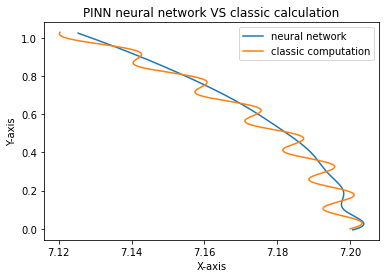

In [51]:
#绘制轨迹，2维
plt.plot(x_coordinates,y_coordinates,linestyle='--', label='PINN')
plt.plot(x_real_plt, y_real_plt,label='VPA')


plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
# plt.title('PINN neural network VS classic calculation')
plt.show()

In [54]:
file_lists = [x_coordinates, y_coordinates, z_coordinates]
file_names = ['hh_outputx.txt', 'hh_outputy.txt', 'hh_outputz.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


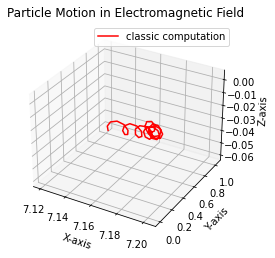

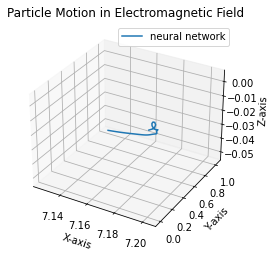

In [55]:
# 绘制轨迹 3维
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_plt[::int(n_all/50)], y_plt[::int(n_all/50)] ,z_plt[::int(n_all/50)],color='red',label='VPA')
#ax.plot(x_coordinates[::int(n_all/100)],y_coordinates[::int(n_all/100)],z_coordinates[::int(n_all/100)],label='neural network')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot(x_plt[::int(n_all/100)], y_plt[::int(n_all/100)] ,z_plt[::int(n_all/100)],label='classic computation')
ax.plot(x_coordinates[::int(n_all/50)],y_coordinates[::int(n_all/50)],z_coordinates[::int(n_all/50)],label='PINN')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field')
plt.show()

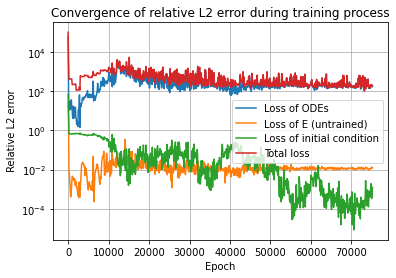

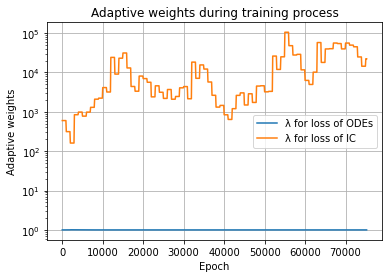

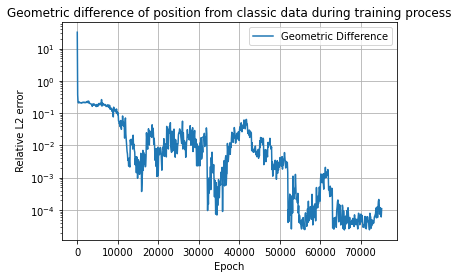

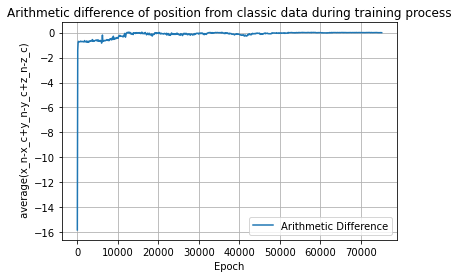

In [58]:
#绘制各loss成分随训练次数epoch变化图
epoch_total = len(loss_list)
epoch_array = np.array(range(0, epoch_total * n_epoch, n_epoch))

plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(epoch_array,lpde_list,label=r'$L_{r}(\theta)$')
#plt.plot(epoch_array,lmiu_list, label='Loss of μ ')
plt.plot(epoch_array,lE_list, label=r'$L_{E}(\theta)$')
plt.plot(epoch_array,l0_list, label=r'$L_{ic}(\theta)$')
plt.plot(epoch_array,loss_list, label=r'$L(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title(r'$Convergence\;of\;rel.\;L^2\;error\;during\;training\;process$')
# 添加图例并设置字体大小，并将其放在图形外部
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))


plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()


plt.plot(epoch_array,lamda1_list,label=r'$λ_{r}(\theta)$')
plt.plot(epoch_array,lamda2_list,label=r'$λ_{E}(\theta)$')
plt.plot(epoch_array,lamda3_list,label=r'$λ_{ic}(\theta)$')
#plt.plot(epoch_array,lamda4_list,label='λ for loss of μ')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Adaptive weights', fontsize='x-large')
# plt.title('Adaptive weights during training process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()#绘图

plt.plot(epoch_array,loss_test_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric difference of position from classic data during training process')

plt.show()#绘图

plt.plot(epoch_array,lossmean_test_list)
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic difference of position from classic data during training process')

plt.show()#绘图

In [59]:
#绘制损失函数在各时刻的分布
lpde_tl_list=[]

lE_tl_list=[]

loss_test_tl_list=[]

lossmean_test_tl_list=[]
for i in range(jump,(n_all+1+jump),10):
    t_tl = torch.tensor([i*interval]).view(-1, 1).requires_grad_(True)#tl:trainloss
    x_tl = u(t_tl)[:,0]
    y_tl = u(t_tl)[:,1]
    z_tl = u(t_tl)[:,2]
    vx_tl = gradients(x_tl, t_tl, 1)
    vy_tl = gradients(y_tl, t_tl, 1)
    vz_tl = gradients(z_tl, t_tl, 1)
    lpde1_tl = loss(gradients(vx_tl, t_tl, 1), q_over_m*(Ex + vy_tl * Bz(x_tl,y_tl,z_tl) - vz_tl * By(x_tl,y_tl,z_tl)))
    lpde2_tl = loss(gradients(vy_tl, t_tl, 1), q_over_m*(Ey + vz_tl * Bx(x_tl,y_tl,z_tl) - vx_tl * Bz(x_tl,y_tl,z_tl)))
    lpde3_tl = loss(gradients(vz_tl, t_tl, 1), q_over_m*(Ez + vx_tl * By(x_tl,y_tl,z_tl) - vy_tl * Bx(x_tl,y_tl,z_tl)))
    lE_tl = loss((vx_tl**2+vy_tl**2+vz_tl**2)**0.5,tensortarget)
    lpde_tl = lpde1_tl + lpde2_tl + lpde3_tl
    x_real_tl = x_real_plt[i-jump]
    y_real_tl = y_real_plt[i-jump]
    z_real_tl = z_real_plt[i-jump]
    vx_real_tl = vx_real_plt[i-jump]
    vy_real_tl = vy_real_plt[i-jump]
    vz_real_tl = vz_real_plt[i-jump]
    loss_test_tl = loss(x_tl,x_real_tl)+loss(y_tl,y_real_tl)+loss(z_tl,z_real_tl)
    lossmean_test_tl = (x_tl-x_real_tl+y_tl-y_real_tl+z_tl-z_real_tl)
    lpde_tl_list.append(lpde_tl.item())
    lE_tl_list.append(lE_tl.item())
    loss_test_tl_list.append(loss_test_tl.item())
    lossmean_test_tl_list.append(lossmean_test_tl.item())
tl_array = np.arange(jump*interval, (n_all+1+jump)*interval, 10*interval)




C:\Users\hxm\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


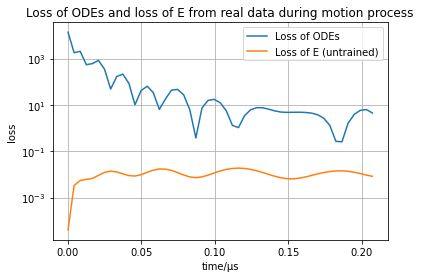

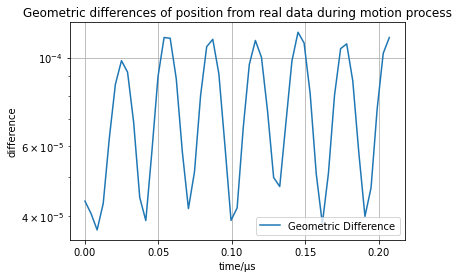

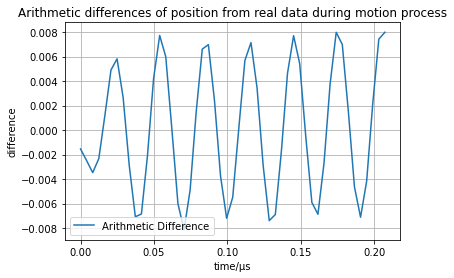

In [61]:
plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(tl_array,lpde_tl_list,label=r'$L_{r}(\theta)$')
plt.plot(tl_array,lE_tl_list,label=r'$L_{E}(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title('Loss of ODEs and loss of E from real data during motion process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()
plt.plot(tl_array,loss_test_tl_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric differences of position from real data during motion process')

plt.show()#绘图
plt.plot(tl_array,lossmean_test_tl_list)
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic differences of position from real data during motion process')

plt.show()#绘图

In [63]:
file_lists = [lpde_tl_list,  lE_tl_list,  loss_test_tl_list, lossmean_test_tl_list]
file_names = ['hh_lpde_tl_list.txt', 'hh_lE_tl_list.txt',  'hh_loss_test_tl_list.txt', 'hh_lossmean_test_tl_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)
